In [2]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import timm  # timm (PyTorch Image Models) library for accessing pre-trained models and utilities for image classification
import os  
from tqdm.notebook import tqdm  # tqdm for displaying progress bars in Jupyter notebooks
from torchvision import transforms as T, datasets
from helper import view_classify, show_image, show_grid, accuracy # Importing custom helper functions for visualization and calculating accuracy

In [3]:
# Configuration class to store hyperparameters and dataset information
class CFG:
    
    epochs = 20  # Number of training epochs
    lr = 0.001   # Learning rate for the optimizer
    batch_size = 16  # Batch size for training and validation

    model_name = 'tf_efficientnet_b4_ns'  # Name of the model to be used, sourced from timm library
    img_size = 224  # Image size for input into the model

    # Paths for dataset directories
    DATA_DIR = "./chest_xray_data"  # Root directory for the dataset
    TEST = 'test'  # Subdirectory for test data
    TRAIN = 'train'  # Subdirectory for training data
    VAL = 'val'  # Subdirectory for validation data

# Setting the device for training/testing. Uses GPU if available, else CPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Print statement to confirm the device being used
print("On which device we are on : {}".format(device))


On which device we are on : cuda:1


In [4]:
# Define transformations for the training dataset
train_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),  # Resize images to the specified size in the CFG class
    T.RandomRotation(degrees=(-20, +20)),  # Apply random rotations between -20 and +20 degrees to augment the data
    T.ToTensor(),  # Convert images to PyTorch tensors
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images using ImageNet's mean and std
])

# Define transformations for the validation dataset
valid_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),  # Resize images to the specified size
    T.ToTensor(),  # Convert images to PyTorch tensors
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images using the same mean and std
])

# Define transformations for the test dataset
test_transform = T.Compose([
    T.Resize(size=(CFG.img_size, CFG.img_size)),  # Resize images to the specified size
    T.ToTensor(),  # Convert images to PyTorch tensors
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images using the same mean and std
])

In [5]:
# Constructing file paths for the training, validation, and test datasets using the CFG class
train_path = os.path.join(CFG.DATA_DIR, CFG.TRAIN)  # Path to the training dataset
valid_path = os.path.join(CFG.DATA_DIR, CFG.VAL)    # Path to the validation dataset
test_path = os.path.join(CFG.DATA_DIR, CFG.TEST)    # Path to the test dataset

print(train_path, valid_path, test_path)

# Loading datasets using ImageFolder, which expects data to be in a certain directory structure
trainset = datasets.ImageFolder(train_path, transform=train_transform)  # Training dataset with transformations
validset = datasets.ImageFolder(valid_path, transform=valid_transform)  # Validation dataset with transformations
testset = datasets.ImageFolder(test_path, transform=test_transform)     # Test dataset with transformations

./chest_xray_data\train ./chest_xray_data\val ./chest_xray_data\test


In [6]:
import torch.nn as nn
model = timm.create_model(CFG.model_name, pretrained=False)  # Create a new instance of the model
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625),  # First linear layer
    nn.ReLU(),  # ReLU activation function
    nn.Dropout(p=0.3),  # Dropout layer with a dropout probability of 0.3
    nn.Linear(in_features=625, out_features=256),  # Second linear layer
    nn.ReLU(),  # ReLU activation function
    nn.Linear(in_features=256, out_features=2)  # Final linear layer with 2 outputs for binary classification
    )

model.load_state_dict(torch.load('PneumoniaModel.pth'))  # Load the saved state_dict
model.to(device)  # Move the model to the desired device
model.eval()  # Set the model to evaluation mode

c:\Users\jxs75\Downloads\EW-zFnstS1evsxZ7LbtXFA_e041c00b6c7b41338e1419006ae2aece_Complete-Code\Complete Code\.venv\lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

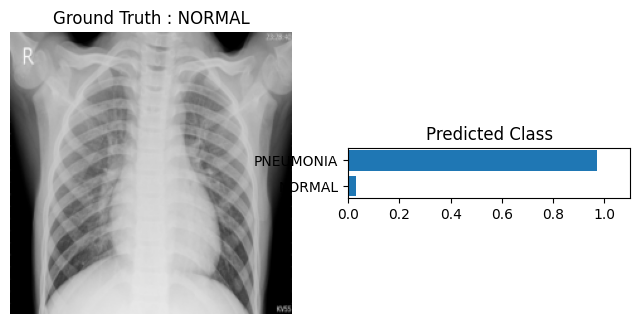

In [7]:
import torch.nn.functional as F 

# Selecting a single image and its label from the test dataset
image, label = testset[123]

# Making a prediction using the model
ps = model(image.to(device).unsqueeze(0)) 

# Applying softmax to the model's output to convert logits to probabilities
ps = F.softmax(ps, dim=1) 

# Displaying the image, the predicted probabilities, and the actual label
view_classify(image, ps, label) 